### Stage-2 selection: compare optimal partition and random selection, using random client pool

Optimal partition: partition client pool using proposed algorithm: Algorithm 1 Make Subsets

Random selection: randomly select one subset from client pool

In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle

In [4]:
def dist_uniform(N, k):
    """Uniform distribution of 'N' items into 'k' groups."""
    dist = []
    avg = N / k
    # Make distribution
    for i in range(k):
        dist.append(int((i + 1) * avg) - int(i * avg))
    # Return shuffled distribution
    random.shuffle(dist)
    return dist

In [53]:
def dist_nid_1(N, k, r=0.9):
    # distribute N items non-uniformly into k groups
    # r: ratio of primary group
    
    # number of items for primary group
    n_prime = int(N * r)
    # which group is primary?
    a = random.choice(range(k))
    
    if r == 1.0:
        h = [0] * k
        h[a] = n_prime
    else:
#         # distribute the rest uniformly over other groups
#         n_rest = N - n_prime
#         h = dist_uniform(n_rest, k-1)
#         # insert primary group
#         h.insert(a, n_prime)
        
        # distribute the rest on one other label b
        n_rest = N - n_prime
        b = random.choice(range(k))
        while b==a:
            b = random.choice(range(k))
        h = [0] * k
        h[a] = n_prime
        h[b] = n_rest
    
    return h

In [55]:
dist_nid_1(100, 10)

[0, 0, 0, 0, 90, 10, 0, 0, 0, 0]

In [59]:
def dist_nid_2(N, k, r1=0.5, r2=0.4):
    # distribute N items non-uniformly into k groups
    # r1, r2: ratios of 1st, 2nd primary groups
    
    # number of items for primary groups
    n1 = int(N * r1)
    n2 = int(N * r2)
    n_rest = N - n1 - n2
    
#     # distribute the rest uniformly over other groups
#     h = dist_uniform(n_rest, k-2)
#     # append primary group, shuffle
#     h.append(n1)
#     h.append(n2)
#     random.shuffle(h)
    
    # distribute the rest on one other label
#     a = random.choices(range(10), k=3)    # with replacement
    a = random.sample(range(10), k=3)     # without replacement
    h = [0] * k
    h[a[0]] = n1
    h[a[1]] = n2
    h[a[2]] = n_rest
    
    return h

In [66]:
dist_nid_2(100, 10)

[0, 0, 40, 0, 0, 0, 0, 50, 10, 0]

In [7]:
# create a data distribution histogram of a client
def make_histo(n_class, n_sample, nid_mode=0):
    # n_class: total number of class labels
    # n_sample: total number of samples for this client
    # nid_mode=0,1,2: iid (uniform), nid1 (90:10), nid2 (50:40:10)
    assert nid_mode in (0, 1, 2, 3, 4)
    
    if nid_mode == 0:
        h = dist_uniform(n_sample, n_class)
    elif nid_mode == 1:
        r_prim = 0.9
        h = dist_nid_1(n_sample, n_class, r_prim)
    elif nid_mode == 2:
        r1, r2 = 0.5, 0.4
        h = dist_nid_2(n_sample, n_class, r1, r2)
    elif nid_mode == 3:
        coin = random.randint(0,1)
        if coin == 0:
            h = dist_nid_1(n_sample, n_class, 0.9)
        else:
            h = dist_nid_2(n_sample, n_class, 0.5, 0.4)
    elif nid_mode == 4:
        h = dist_nid_1(n_sample, n_class, 1)
    
    return h

In [8]:
random.randint(0,1)

1

In [9]:
# compute non-iid degree given a histogram: new definition: (max - min) / total
def nid(h):
    l = list(h)
    return (max(l) - min(l)) / sum(l)

In [10]:
# create a set of histograms (client pool): 
def make_histo_set(n_client, n_sample, n_class, nid_mode, dif=0):
    # n_sample: total number of samples for all clients
    # dif: difference from average number of samples to allow for each client
    # nid_mode=3: randomly select between 1 and 2
    pool = []
    
    ave = n_sample // n_client
    
    if nid_mode in (0,1,2,4):
        if dif == 0:        # each client has the same number of samples
            n_sample_i = ave
            for i in range(n_client):
                h = make_histo(n_class, n_sample_i, nid_mode)
                pool.append(h)

        else:              # each client has different number of samples
            d = int(ave * dif)
#             a, b = ave - d, ave + d
            a, b = int(0.7 * ave - d), int(0.7 * ave + d)

            for i in range(n_client):
                n_sample_i = random.choice(range(a, b+1))
                h = make_histo(n_class, n_sample_i, nid_mode)
                pool.append(h)
    
    elif nid_mode == 3:
        if dif == 0:        # each client has the same number of samples
            n_sample_i = ave
            for i in range(n_client):
                h = make_histo(n_class, n_sample_i, random.choice(range(1, 3)))
                pool.append(h)

        else:              # each client has different number of samples
            d = int(ave * dif)
            a, b = int(0.7 * ave - d), int(0.7 * ave + d)

            for i in range(n_client):
                n_sample_i = random.choice(range(a, b+1))
                h = make_histo(n_class, n_sample_i, random.choice(range(1, 3)))
                pool.append(h)
    
    return pool

In [11]:
# Select one subset using MKP (multi knapsack problem), with subset size constraint
def select_mkp(histos, bounds, n_min, n_max):
    # histos: list or array, data distribution (over labels) histograms
    # bounds: bound on number of samples for each label, for selected subset
    # n_min, n_max: bounds for selected subset size (number of selected items)
    
    assert histos.shape[1] == len(bounds)
    
#     A = np.array(histos).T
#     b = np.array(bounds)
    A = np.append(np.array(histos).T, [[1]*histos.shape[0], [-1]*histos.shape[0]], axis=0)
    A = np.where(A==0, 0.000001, A)        # to avoid error in adding constraints
    b = np.append(np.array(bounds), [n_max, -n_min], axis=0)
    
    import cplex
    from docplex.mp.model import Model
    
    c = np.array(histos).sum(axis=1)
    nCols, nRows = range(len(c)), range(len(b))
    
    # define problem
    mkp = Model('MKP')
    x = mkp.binary_var_list(nCols, lb = 0, ub = 1, name = 'x')
    constraints = mkp.add_constraints(sum(A[i][j] * x[j] for j in nCols) <= b[i] for i in nRows)
    objective = mkp.sum(c[j] * x[j] for j in nCols)   
    obj = mkp.maximize(objective)
    
    # solve problem
    print('\tsolving mkp problem ...')
    mkp.solve()
    print('\tdone.')
    sol_ind = []
    for variable, value in mkp.solution.iter_var_values():
        if int(value) == 1: 
            ind = int(str(variable)[2:])
            sol_ind.append(ind)
    
    selected_items = [histos[i] for i in sol_ind]
    sol_obj = int(mkp.solution.get_objective_value())
    
    return sol_ind, selected_items, sol_obj

In [12]:
# Compute upper bound for MKP problem
def mkp_bound(histos, n_round, r1=0.5, r2=1.5, low_bound=False):
    # r1: range 0~1
    # r2: range 1~
    label_max = max(np.array(histos).sum(axis=0))
    b1, b2 = label_max / n_round, label_max / (n_round-1)
    if low_bound:
        bound = r2 * np.array(histos).max()
    else: 
        bound = int(b1 + r1 * (b2 - b1))
    return bound

In [13]:
# Generate subsets by selecting mkp subsets continously
def generate_subsets(histos, n_round, bound, select_times_max=3, delta=2, nid_bound=0.05):
    # histos: list of histotrams of clients
    # bound: upper bound for MKP problem
    # select_times_max: maximum number of times a client can be selected
    # delta: tolerance on subset size
    print('Generating subsets ...')
    
    n_class = np.array(histos).shape[1]
    bounds = np.array([bound]*n_class)
    print('total number of candidates: ', len(histos))
    print('bounds: ', bounds)
    # record client information: id, primary class, select times
    client_infos = pd.DataFrame(index=range(len(histos)))
    for i in range(len(histos)):
        client_infos.loc[i, 'client_id'] = i
        client_infos.loc[i, 'prim_class'] = np.argmax(histos[i])
        client_infos.loc[i, 'select_times'] = 0
        for j in range(n_class):
            client_infos.loc[i, 'class '+str(j)] = histos[i][j]
    
    rest_clients = client_infos[client_infos['select_times']==0].iloc[:, 3:]
    subsets = []        # each subset is a dataframe indexed by client id
    subset_n = 1
    n_ave = len(histos) // n_round      # average subset size
#     n_min, n_max = n_ave - delta, n_ave + delta
    n_min, n_max = 1, n_ave + delta
    
    while not rest_clients.empty:
        if len(rest_clients) >= (n_ave - delta):    # add in Copy4
            # generate a subset    
            print('\n'+str(subset_n)+'th subset')
            sol_ind, selected_items, sol_obj = select_mkp(np.array(rest_clients), bounds, n_min, n_max)
            print('selected clients: ', list(rest_clients.iloc[sol_ind, :].index))

            # check nid of subset
            h_integ = np.array(selected_items).sum(axis=0)
            sub_nid = nid(h_integ)
            print('Nid of subset: ', sub_nid)
            
            # moved up in Copy4: selected clients
            sub = rest_clients.iloc[sol_ind, :]
            
            # improve nid by adding compensation clients
            # find clients not in rest clients and can be still selected
            more = client_infos[(client_infos['select_times']>0) & (client_infos['select_times']<select_times_max)]
            if sub_nid > nid_bound:
                # find which classes need compensation
                comp_classes = []
                for i in range(len(h_integ)):
                    if h_integ[i] < bound * 0.8:
                        comp_classes.append(i)
                # find compensation clients whose prim class is in comp_classes
                add_client = more[more['prim_class'].isin(comp_classes)]
                # add found clients to rest_clients and select again
                # Copy4: make sure rest clients are reduced after reselection
                if not add_client.empty:
                    print('add clients: ', list(add_client.index), ', and select again')
                    new_rest_clients = pd.concat([rest_clients, add_client.iloc[:, 3:]])
                    new_sol_ind, new_selected_items, sol_obj = select_mkp(np.array(new_rest_clients), bounds, n_min, n_max)
                    
                    rest_ids = list(rest_clients.index)
                    new_sub_ids = list(new_rest_clients.iloc[new_sol_ind, :].index)
                    if any(i in rest_ids for i in new_sub_ids):    # remaining clients are reduced
                        print('new selected clients: ', new_sub_ids)
                        h_integ = np.array(new_selected_items).sum(axis=0)
                        sub_nid = nid(h_integ)
                        print('Nid of subset: ', sub_nid)
                        sub = new_rest_clients.iloc[new_sol_ind, :]
                    else: print('remaining clients are not selected after adding.')
                        
                else:
                    print('no clients to add.')

            
            
            if len(sub) < (n_ave - delta):
                print("\nToo few clients selected, select at least some and find complement.")
                last_clients = client_infos[client_infos['select_times']==0].iloc[:(n_ave - delta), 3:]
                print("left clients:", list(last_clients.index))
                h_last = np.array(last_clients).sum(axis=0)
                # complement histogram for h_last
                last_bounds = [1.1*max(h_last)-h for h in h_last]
                # select, from other selectable clients, complement set under last_bounds
                try: 
                    comp_ind, comp_items, comp_obj = select_mkp(np.array(more.iloc[:, 3:]), last_bounds, n_min, 2*delta)
                    print("\tcomplement found.")
                except: 
                    comp_ind = []
                    print("\tcomplement not found.")
                comp_sub = more.iloc[comp_ind, 3:]
                sub = pd.concat([last_clients, comp_sub])
                print("selected clients: ", list(sub.index))
                print('Nid of subset: ', nid(np.array(sub).sum(axis=0)))
        
        # added in Copy4: if the number of remaining clients are too few
        else:
            print('\n'+str(subset_n)+'th subset')
            print("Too few clients left, select all and find complement.")
            last_clients = client_infos[client_infos['select_times']==0].iloc[:, 3:]
            print("left clients:", list(last_clients.index))
            h_last = np.array(last_clients).sum(axis=0)
            # complement histogram for h_last
            last_bounds = [1.1*max(h_last)-h for h in h_last]
            # select, from other selectable clients, complement set under last_bounds
            try: 
                new_n_max = n_max - len(last_clients)
                comp_ind, comp_items, comp_obj = select_mkp(np.array(more.iloc[:, 3:]), last_bounds, n_min, new_n_max)
                print("\tcomplement found.")
            except: 
                comp_ind = []
                print("\tcomplement not found.")
            comp_sub = more.iloc[comp_ind, 3:]
            sub = pd.concat([last_clients, comp_sub])
            print("last selected clients: ", list(sub.index))
            print('Nid of subset: ', nid(np.array(sub).sum(axis=0)))
        
        # save selected clients as dataframe, collect subsets
#         sub = rest_clients.iloc[sol_ind, :]
        subsets.append(sub)
        
        # update select_times in client_infos
        for k in sub.index:
            client_infos.loc[k, 'select_times'] += 1
        
        # update rest_clients
        rest_clients = client_infos[client_infos['select_times']==0].iloc[:, 3:]
        print('remaining clients: ', list(rest_clients.index))
        print('number of remaining clients:', rest_clients.shape[0])
        
        subset_n += 1
    
    return subsets, client_infos

In [14]:
# Generate subsets by selecting subsets randomly
def random_subsets(histos, n_round, n_subset, delta=2):
    print('Generating random subsets ...')
    print('total number of candidates: ', len(histos))
    
    # record client information: id, primary class, select times
    client_infos = pd.DataFrame(index=range(len(histos)))
    for i in range(len(histos)):
        client_infos.loc[i, 'client_id'] = i
        client_infos.loc[i, 'prim_class'] = np.argmax(histos[i])
        client_infos.loc[i, 'select_times'] = 0
        for j in range(n_class):
            client_infos.loc[i, 'class '+str(j)] = histos[i][j]
    
    rest_clients = client_infos.iloc[:, 3:]
    subsets = []        # each subset is a dataframe indexed by client id
    subset_n = 1
#     while not rest_clients.empty:
    for i in range(n_subset):
        # generate a subset
        print('\n'+str(subset_n)+'th subset')
        # subset size: n
#         n = random.randint((len(histos) // n_round - delta), (len(histos) // n_round + delta))
        n = random.randint((len(histos) // n_round), (len(histos) // n_round + delta))
        sol_ind = random.choices(list(range(len(histos))), k=n)
        selected_items = [histos[j] for j in sol_ind]
        print('selected clients: ', list(rest_clients.iloc[sol_ind, :].index))
            
        # check nid of subset
        h_integ = np.array(selected_items).sum(axis=0)
        sub_nid = nid(h_integ)
        print('nid of subset: ', sub_nid)
        
        # save selected clients as dataframe, collect subsets
        sub = rest_clients.iloc[sol_ind, :]
        subsets.append(sub)
        
        # update select_times in client_infos
        for k in sub.index:
            client_infos.loc[k, 'select_times'] += 1
        
        subset_n += 1
    
    return subsets, client_infos

### Experiment

nid_mode 1: 9:1, each client has data for 2 labels

nid_mode 2: 5:4:1, each client has data for 3 labels

In [88]:
n_client = 100 
n_sample = 50000 
n_class = 10
nid_mode = 2
n_round = 10

In [99]:
# pool = make_histo_set(n_client, n_sample, n_class, nid_mode, dif=0.5)
pool = make_histo_set(n_client, n_sample, n_class, nid_mode, dif=0)
pool

[[0, 50, 0, 0, 200, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 200, 0, 0, 50, 0, 250],
 [0, 0, 0, 200, 0, 0, 0, 50, 0, 0],
 [0, 0, 200, 0, 0, 0, 50, 0, 250, 0],
 [50, 0, 250, 200, 0, 0, 0, 0, 0, 0],
 [250, 0, 0, 0, 0, 0, 50, 0, 0, 200],
 [0, 0, 200, 50, 0, 0, 0, 0, 0, 0],
 [250, 0, 0, 0, 0, 0, 50, 0, 0, 0],
 [0, 0, 250, 50, 0, 0, 200, 0, 0, 0],
 [0, 0, 250, 0, 0, 0, 0, 50, 200, 0],
 [0, 250, 0, 0, 0, 0, 0, 0, 200, 50],
 [50, 0, 0, 0, 0, 0, 0, 250, 0, 0],
 [0, 0, 250, 0, 200, 50, 0, 0, 0, 0],
 [0, 250, 0, 0, 50, 0, 200, 0, 0, 0],
 [50, 0, 0, 0, 0, 0, 0, 250, 200, 0],
 [0, 50, 250, 0, 200, 0, 0, 0, 0, 0],
 [50, 250, 0, 200, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 200, 0, 0, 0, 50],
 [250, 0, 0, 0, 50, 200, 0, 0, 0, 0],
 [0, 0, 50, 0, 0, 0, 0, 0, 250, 0],
 [0, 250, 50, 0, 0, 0, 0, 200, 0, 0],
 [200, 0, 0, 250, 0, 0, 50, 0, 0, 0],
 [250, 0, 0, 0, 0, 0, 200, 0, 50, 0],
 [200, 0, 0, 0, 0, 50, 0, 0, 0, 250],
 [50, 0, 0, 0, 0, 0, 0, 0, 0, 250],
 [0, 200, 0, 250, 0, 0, 0, 0, 50, 0],
 [0, 0, 0, 0, 250, 0, 0, 0, 

In [92]:
pool1 = pool

In [17]:
nid(np.array(pool).sum(axis=0))

0.11

In [18]:
np.array(pool).sum(axis=0)

array([3500, 6000, 3000, 5500, 6500, 4000, 5000, 6000, 8000, 2500])

#### Optimal partition with Algorithm 1

In [100]:
bound = mkp_bound(pool, n_round, low_bound=False)
subsets, client_infos = generate_subsets(pool, n_round, bound, select_times_max=3, delta=3)

Generating subsets ...
total number of candidates:  100
bounds:  [591 591 591 591 591 591 591 591 591 591]

1th subset
	solving mkp problem ...
	done.
selected clients:  [7, 10, 11, 23, 34, 39, 41, 42, 50, 55, 76, 79, 98]
Nid of subset:  0.009433962264150943
remaining clients:  [0, 1, 2, 3, 4, 5, 6, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 40, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99]
number of remaining clients: 87

2th subset
	solving mkp problem ...
	done.
selected clients:  [3, 19, 20, 24, 26, 27, 59, 61, 63, 66, 87, 93, 96]
Nid of subset:  0.018867924528301886
remaining clients:  [0, 1, 2, 4, 5, 6, 8, 9, 12, 13, 14, 15, 16, 17, 18, 21, 22, 25, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 40, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 56, 57, 58, 60, 62, 64, 

In [20]:
len(client_infos[client_infos['select_times']!=1])

57

In [21]:
bound

844

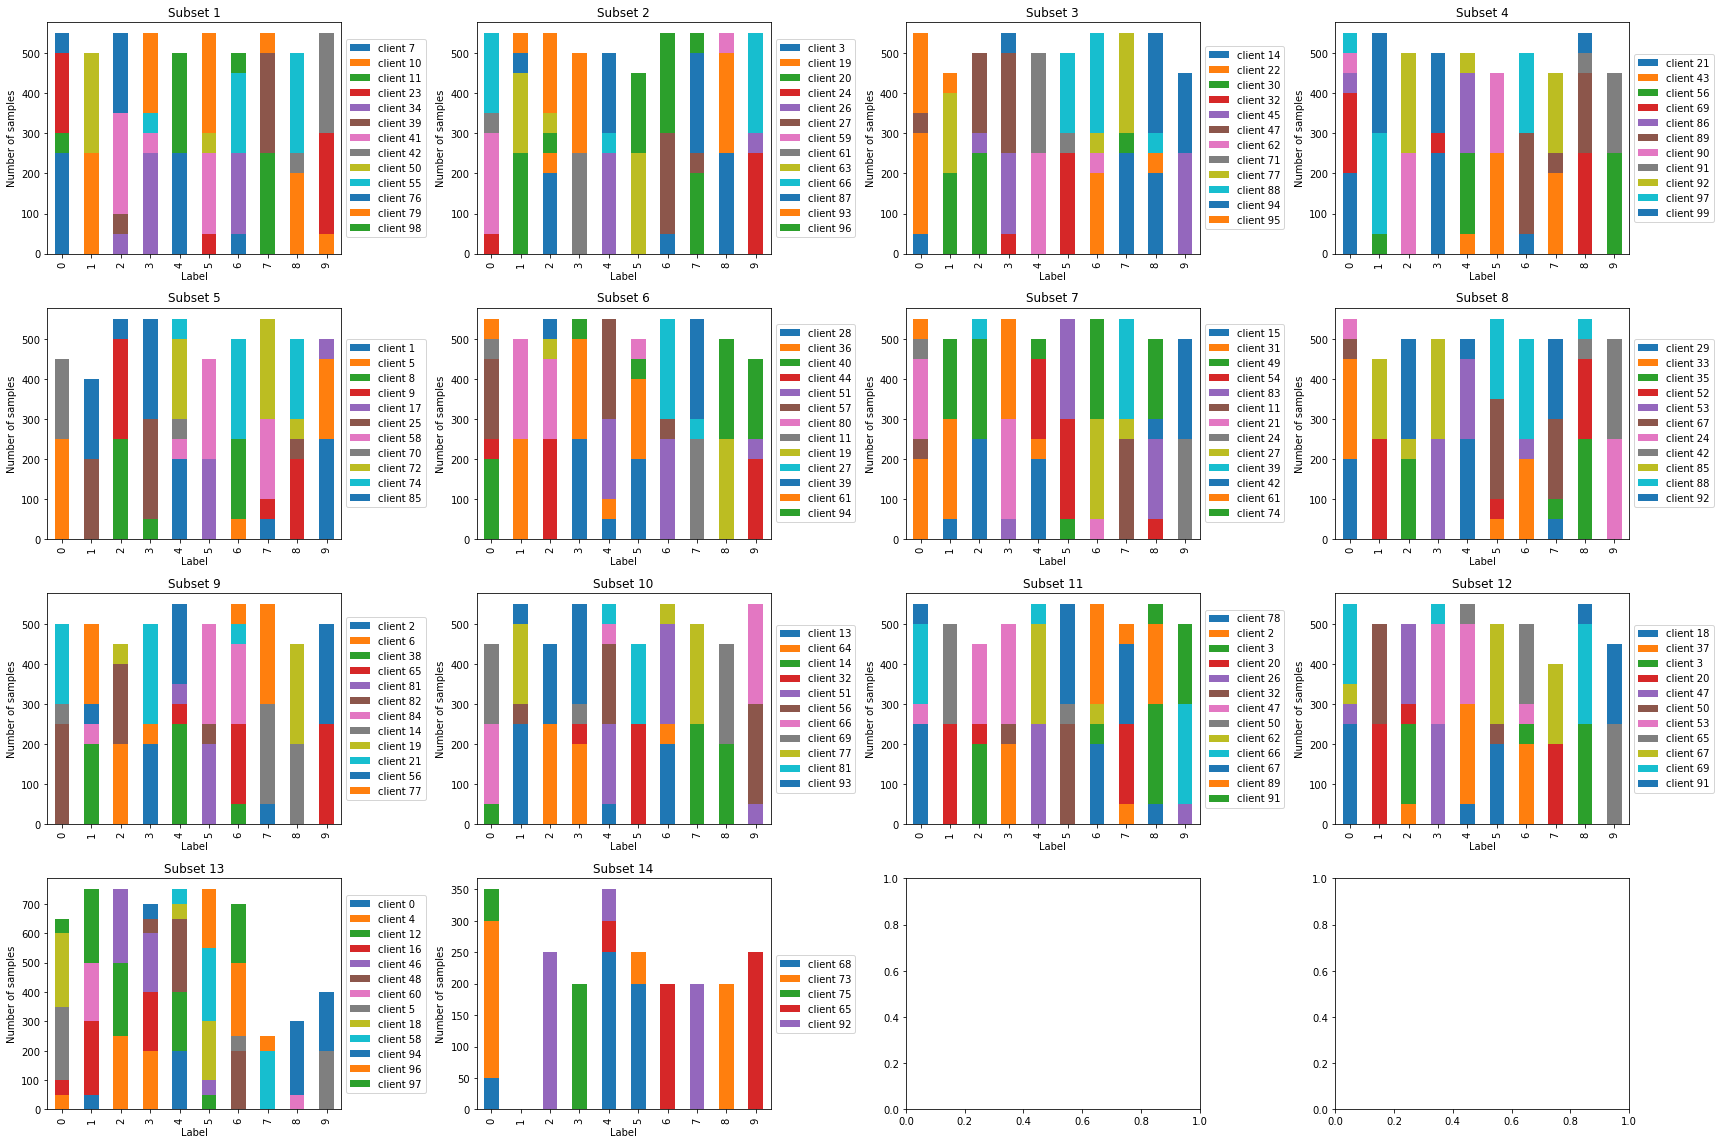

In [101]:
ncols = 4
nrows = len(subsets) // ncols + int(bool(len(subsets) % ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24, 4*nrows))
for i in range(len(subsets)):
    cols = ['client ' + str(i) for i in subsets[i].index]
    df = pd.DataFrame(np.array(subsets[i]).T, columns = cols)
    df.plot.bar(ax=axes[i//ncols,i%ncols], title='Subset '+str(i+1), xlabel='Label', ylabel='Number of samples', stacked=True)
    axes[i//ncols,i%ncols].legend(loc='center left', bbox_to_anchor=(1, 0.5)) 

# axes[-1, -1].axis('off')
plt.tight_layout()
# plt.savefig('opt_subsets_9nid_1.pdf')
plt.show()

In [102]:
subset_sizes = []
subset_nids = []
for sub in subsets:
    subset_sizes.append(sub.shape[0])
    subset_nids.append(round(nid(np.array(sub).sum(axis=0)), 3))
print("Number of Subsets: ", len(subsets), "\nSubset Size: ", subset_sizes, "\nSubset Nid: ", subset_nids)

Number of Subsets:  14 
Subset Size:  [13, 13, 12, 11, 11, 13, 13, 11, 12, 11, 13, 11, 13, 5] 
Subset Nid:  [0.009, 0.019, 0.019, 0.02, 0.03, 0.019, 0.009, 0.02, 0.02, 0.02, 0.019, 0.03, 0.083, 0.156]


In [131]:
client_infos[client_infos['prim_class']==6]

,client_id,prim_class,select_times,class 0,class 1,class 2,class 3,class 4,class 5,class 6,class 7,class 8,class 9
40,40.0,6.0,3.0,6.0,7.0,6.0,7.0,6.0,7.0,540.0,7.0,7.0,7.0
47,47.0,6.0,3.0,7.0,7.0,8.0,7.0,8.0,7.0,300.0,8.0,240.0,8.0
87,87.0,6.0,2.0,8.0,8.0,7.0,240.0,8.0,8.0,300.0,7.0,7.0,7.0
97,97.0,6.0,2.0,7.0,240.0,7.0,7.0,8.0,8.0,300.0,8.0,8.0,7.0


In [82]:
np.array(pool).sum(axis=1).max()

707

In [103]:
client_infos[client_infos['select_times']==0]

,client_id,prim_class,select_times,class 0,class 1,class 2,class 3,class 4,class 5,class 6,class 7,class 8,class 9


#### Random selection for comparison

In [104]:
n_subset = len(subsets)
rand_subsets, rand_client_infos = random_subsets(pool, n_round, n_subset, delta=0)

Generating random subsets ...
total number of candidates:  100

1th subset
selected clients:  [80, 36, 1, 83, 25, 54, 86, 23, 88, 81]
nid of subset:  0.25555555555555554

2th subset
selected clients:  [35, 72, 41, 6, 66, 91, 68, 12, 51, 3]
nid of subset:  0.24444444444444444

3th subset
selected clients:  [27, 92, 35, 50, 23, 2, 3, 18, 82, 70]
nid of subset:  0.18292682926829268

4th subset
selected clients:  [23, 26, 84, 0, 41, 76, 23, 15, 72, 0]
nid of subset:  0.29069767441860467

5th subset
selected clients:  [50, 45, 71, 68, 10, 1, 11, 51, 99, 65]
nid of subset:  0.20454545454545456

6th subset
selected clients:  [48, 0, 73, 34, 11, 90, 46, 28, 39, 4]
nid of subset:  0.21839080459770116

7th subset
selected clients:  [10, 32, 2, 57, 14, 12, 9, 11, 33, 48]
nid of subset:  0.14942528735632185

8th subset
selected clients:  [97, 57, 62, 83, 0, 69, 1, 98, 42, 23]
nid of subset:  0.27710843373493976

9th subset
selected clients:  [53, 53, 16, 78, 39, 98, 78, 0, 50, 45]
nid of subset:  

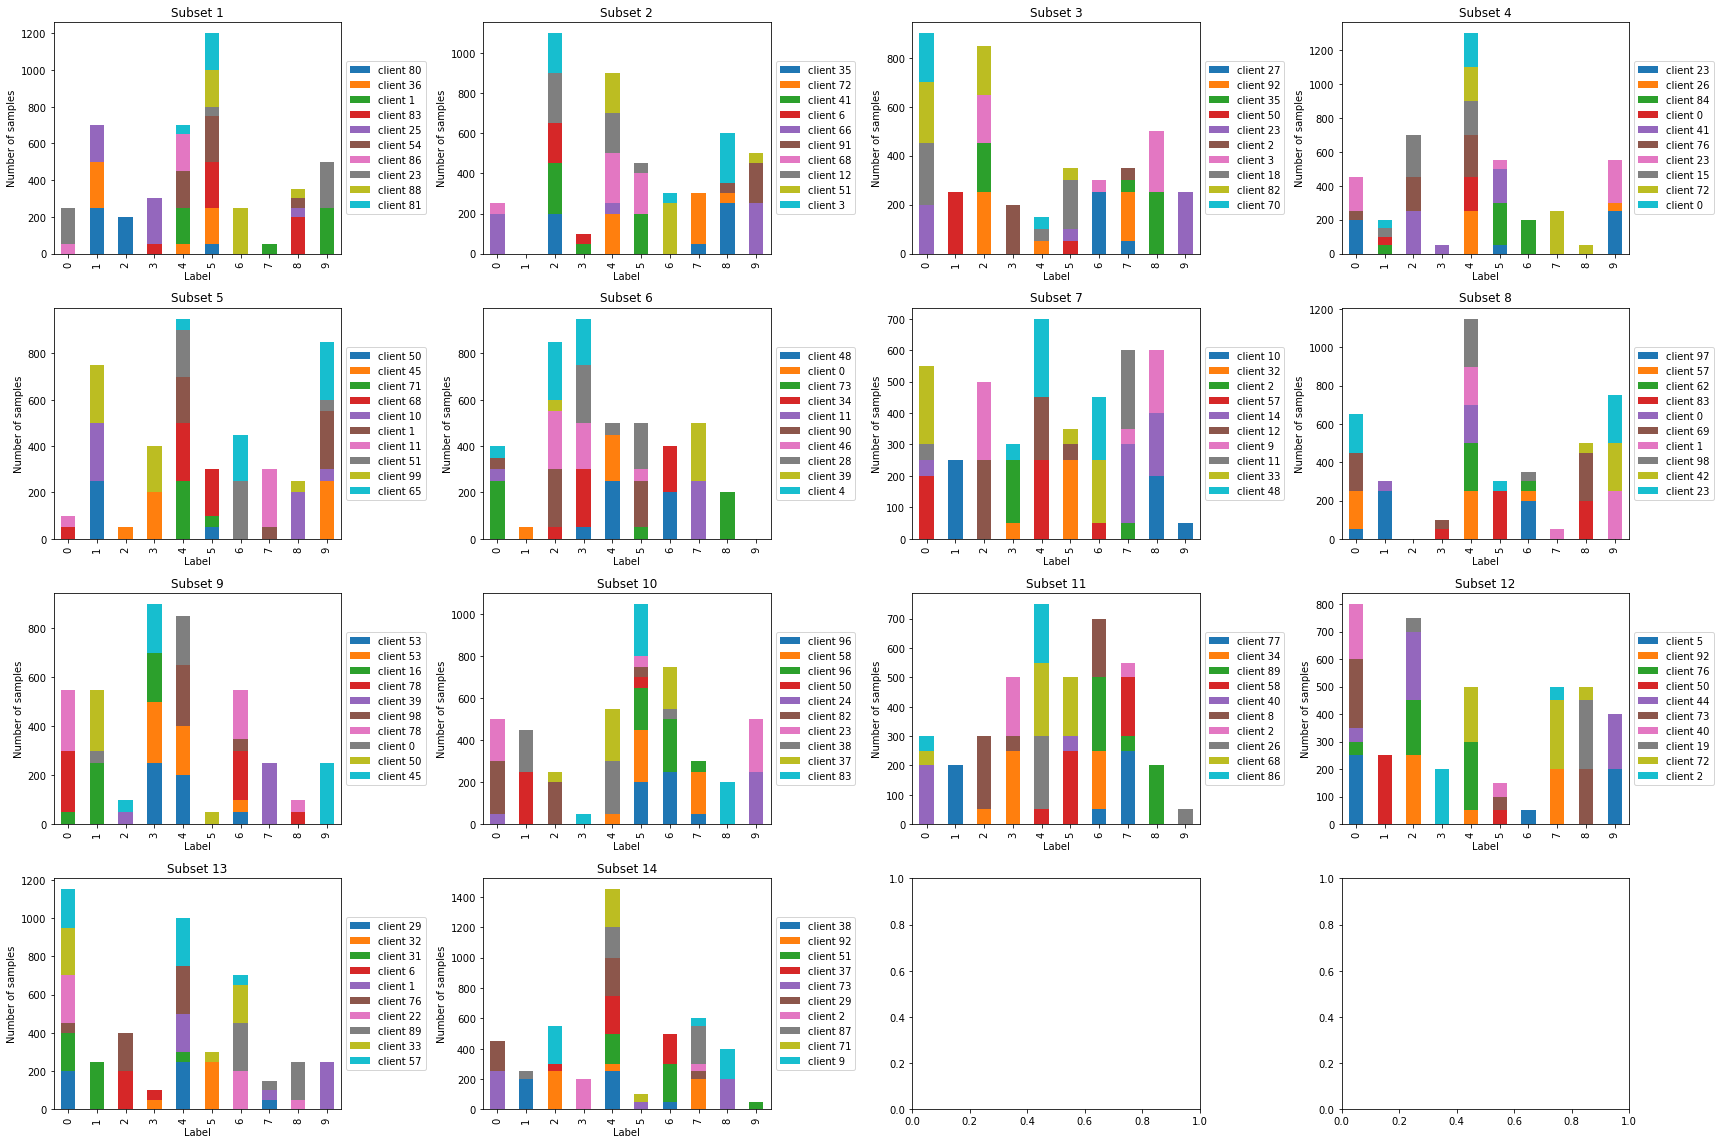

In [105]:
ncols = 4
nrows = len(rand_subsets) // ncols + int(bool(len(rand_subsets) % ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24, 4*nrows))
for i in range(len(rand_subsets)):
    cols = ['client ' + str(i) for i in rand_subsets[i].index]
    df = pd.DataFrame(np.array(rand_subsets[i]).T, columns = cols)
    df.plot.bar(ax=axes[i//ncols,i%ncols], title='Subset '+str(i+1), xlabel='Label', ylabel='Number of samples', stacked=True)
    axes[i//ncols,i%ncols].legend(loc='center left', bbox_to_anchor=(1, 0.5)) 

# axes[-1, -1].axis('off')
plt.tight_layout()
# plt.savefig('opt_subsets_9nid_1.pdf')
plt.show()

In [106]:
rand_subset_sizes = []
rand_subset_nids = []
for sub in rand_subsets:
    rand_subset_sizes.append(sub.shape[0])
    rand_subset_nids.append(round(nid(np.array(sub).sum(axis=0)), 3))
print("Number of Subsets: ", len(rand_subsets), "\nSubset Size: ", rand_subset_sizes, "\nSubset Nid: ", rand_subset_nids)

Number of Subsets:  14 
Subset Size:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10] 
Subset Nid:  [0.256, 0.244, 0.183, 0.291, 0.205, 0.218, 0.149, 0.277, 0.205, 0.217, 0.173, 0.183, 0.231, 0.308]


In [51]:
rand_client_infos[rand_client_infos['select_times']==0]

,client_id,prim_class,select_times,class 0,class 1,class 2,class 3,class 4,class 5,class 6,class 7,class 8,class 9
2,2.0,1.0,0.0,0.0,600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,9.0,0.0,0.0,600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,13.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,600.0,0.0
14,14.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,600.0,0.0,0.0,0.0,0.0
20,20.0,1.0,0.0,0.0,600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,24.0,3.0,0.0,0.0,0.0,0.0,600.0,0.0,0.0,0.0,0.0,0.0,0.0
26,26.0,4.0,0.0,0.0,0.0,0.0,0.0,600.0,0.0,0.0,0.0,0.0,0.0
28,28.0,3.0,0.0,0.0,0.0,0.0,600.0,0.0,0.0,0.0,0.0,0.0,0.0
35,35.0,4.0,0.0,0.0,0.0,0.0,0.0,600.0,0.0,0.0,0.0,0.0,0.0
40,40.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,600.0,0.0,0.0,0.0
